# Project Delivery Part 2 — Weeks 3 & 4

In this second delivery, we move from the rule-based scoring system developed in Week 1 to a **machine-learning approach**. The goal remains the same: identify which clients to contact for investment products. However, instead of manually defined business rules, we now train classification models (Decision Tree and Logistic Regression) on historical data and use their predicted probabilities to rank clients.

Additionally, we now have **feedback from Period 1** — the results of the 1,200 clients we chose to contact in the first submission. This allows us to enlarge our training data with real outcomes and refine our predictions for Period 2.

## 1. Setup and Imports

We import all necessary libraries upfront. The workflow is organised into four blocks: data handling (`numpy`, `pandas`), preprocessing (`sklearn.pipeline`, `sklearn.impute`, `sklearn.preprocessing`), modeling and tuning (`DecisionTreeClassifier`, `LogisticRegression`, `GridSearchCV`), and evaluation/visualisation (`roc_auc_score`, `matplotlib`, `seaborn`).

In [2]:
# Core
import numpy as np
import pandas as pd

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_selection import VarianceThreshold


# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             classification_report, RocCurveDisplay, accuracy_score)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree


## 2. Data Loading

We load four datasets:

- **`period_0.csv`** — Historical data with 7,700 clients including known investment outcomes. This is our primary training data.
- **`period_1_prediction.csv`** — The 7,700 clients from Period 1 (features only, no outcomes).
- **`period_2_prediction.csv`** — The 7,700 clients from Period 2 for which we must make predictions.
- **`results-2026-02-26.csv`** — Actual investment results for the 1,200 clients we selected in Submission 1. This feedback allows us to enlarge our training set.

In [3]:
df_0 = pd.read_csv("period_0.csv")
df_1 = pd.read_csv("period_1_prediction.csv")
df_2 = pd.read_csv("period_2_prediction.csv")
df_1_result=pd.read_csv("results-2026-02-26.csv")

print(f"Period 0: {df_0.shape}")
print(f"Period 1: {df_1.shape}")
print(f"Period 2: {df_2.shape}")
print(f"Period 1 result {df_1_result.shape}")

Period 0: (7700, 14)
Period 1: (7700, 12)
Period 2: (7700, 12)
Period 1 result (1200, 4)


## 3. Data Inspection

Before any modeling, we inspect the structure and content of the historical dataset (Period 0). This helps us understand feature types, detect missing values, and plan preprocessing steps.

In [4]:
df_0.head()





,id,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,call_length,investment,period
0,1,31,entrepreneur,single,tertiary,cellular,38,no,no,0,unknown,185,0.00,0
1,2,29,management,married,tertiary,cellular,1022,yes,no,0,unknown,408,0.00,0
2,3,49,blue-collar,divorced,secondary,cellular,10613,no,yes,0,unknown,1226,1264.69,0
3,4,23,management,single,tertiary,cellular,736,yes,no,0,unknown,119,0.00,0
4,5,42,technician,married,secondary,NaN,-158,yes,no,0,unknown,124,0.00,0


In [5]:
df_0.info()

<class 'pandas.DataFrame'>
RangeIndex: 7700 entries, 0 to 7699
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    7700 non-null   int64  
 1   age                   7700 non-null   int64  
 2   job                   7657 non-null   str    
 3   marital               7700 non-null   str    
 4   education             7403 non-null   str    
 5   preferred_contact     5473 non-null   str    
 6   balance               7700 non-null   int64  
 7   loan_house            7700 non-null   str    
 8   loan_personal         7700 non-null   str    
 9   n_marketing_contacts  7700 non-null   int64  
 10  marketing_potential   7700 non-null   str    
 11  call_length           7700 non-null   int64  
 12  investment            7700 non-null   float64
 13  period                7700 non-null   int64  
dtypes: float64(1), int64(6), str(7)
memory usage: 842.3 KB


The dataset contains 14 columns with a mix of numerical and categorical features. Missing values exist in `job` (43 missing), `education` (297 missing), and `preferred_contact` (2,227 missing). These will be handled in the preprocessing pipeline. The target-relevant column `investment` is fully populated.

## 4. Data Preparation

### 4.1 Merging Period 1 Results into the Training Data

A key improvement over Delivery 1 is that we now have **real feedback**: for the 1,200 clients we contacted in Period 1, we know whether they actually invested. We merge this outcome data back into the feature set and concatenate it with Period 0 to create an **enlarged training dataset** (8,900 rows instead of 7,700). More training data — especially with fresh, real-world outcomes — helps the model learn more robust patterns.

In [6]:
#show head of results-2026-02-26.csv
df_1_result.head()

,id,investment,week_id,timestamp
0,7712,0.00,1,20260213121907
1,7721,529.92,1,20260213121907
2,7725,0.00,1,20260213121907
3,7726,436.40,1,20260213121907
4,7732,0.00,1,20260213121907


In [7]:
df_period0_raw = pd.read_csv("period_0.csv")

# Step 1: Use ALL IDs from the results file
result_ids = df_1_result['id']
print(f"IDs in results file: {len(result_ids)}")

# Step 2: Get their characteristics from period_1_prediction.csv
df_period1_selected = df_1[df_1['id'].isin(result_ids)].copy()
print(f"Matched in period_1_prediction.csv: {len(df_period1_selected)}")

# Step 3: Join actual investment amount from results file
df_period1_selected = df_period1_selected.merge(
    df_1_result[['id', 'investment']], on='id', how='left'
)

# Step 4: Add binary invested indicator
df_period1_selected['invested'] = (df_period1_selected['investment'] > 0).astype(int)

print(f"\nPeriod 1 — actual investors:  {df_period1_selected['invested'].sum()}")
print(f"Period 1 — did not invest:    {(df_period1_selected['invested'] == 0).sum()}")
print(f"Period 1 — investment NaN:    {df_period1_selected['investment'].isna().sum()}")

# Step 5: Concatenate with period_0
Enlarged_dataset = pd.concat([df_period0_raw, df_period1_selected], ignore_index=True)

# Step 6: Flag correctly predicted — period==1 AND actually invested
Enlarged_dataset['correctly_predicted'] = (
    (Enlarged_dataset['period'] == 1) & (Enlarged_dataset['invested'] > 0)
).astype(int)

print(f"\nPeriod 0 rows:          {len(df_period0_raw)}")
print(f"Period 1 rows added:    {len(df_period1_selected)}")
print(f"Enlarged dataset total: {len(Enlarged_dataset)}")
print(f"Correctly predicted:    {Enlarged_dataset['correctly_predicted'].sum()}")


IDs in results file: 1200
Matched in period_1_prediction.csv: 1200

Period 1 — actual investors:  251
Period 1 — did not invest:    949
Period 1 — investment NaN:    0

Period 0 rows:          7700
Period 1 rows added:    1200
Enlarged dataset total: 8900
Correctly predicted:    251


The merge proceeds in six steps:

1. We take all 1,200 IDs from the results file.
2. We retrieve their feature rows from `period_1_prediction.csv`.
3. We join the actual `investment` amount from the results.
4. We create a binary `invested` flag (1 if investment > 0).
5. We concatenate these rows with the original Period 0 data.
6. We flag correctly predicted investors for later analysis.

Of the 1,200 contacted clients, 251 actually invested — a conversion rate of ~21%, which is higher than the ~10% base rate in Period 0. This confirms that our Period 1 selection strategy already outperformed random selection.

In [8]:
print(Enlarged_dataset)

         id  age           job   marital  education preferred_contact  \
0         1   31  entrepreneur    single   tertiary          cellular   
1         2   29    management   married   tertiary          cellular   
2         3   49   blue-collar  divorced  secondary          cellular   
3         4   23    management    single   tertiary          cellular   
4         5   42    technician   married  secondary               NaN   
...     ...  ...           ...       ...        ...               ...   
8895  15372   50    unemployed    single  secondary         telephone   
8896  15376   36    technician    single  secondary          cellular   
8897  15384   41    management   married   tertiary               NaN   
8898  15396   34      services   married  secondary          cellular   
8899  15400   53    management   married   tertiary          cellular   

       balance loan_house loan_personal  n_marketing_contacts  \
0        38.00         no            no                   

### 4.2 Creating the Target Variable

Our prediction target is **profitability**, not just whether someone invests. A contact costs €5, and Amundi earns 4.5% commission on the invested amount. Therefore:

**profit = investment × 0.045 − 5**

A client is labelled `profit_status = 1` if this profit is positive (i.e., investment > €111.11). This framing directly aligns the model with the business objective: maximise total profit, not just the number of investors.

In [9]:
Enlarged_dataset["profit"] = (Enlarged_dataset["investment"].values * 0.045) - 5
Enlarged_dataset["profit_status"] = (Enlarged_dataset["profit"] > 0).astype(int)
print(f"profit_rate: {Enlarged_dataset['profit_status'].mean():.3f}")
print(f"\nDistribution:")
print(Enlarged_dataset['profit_status'].value_counts())

profit_rate: 0.116

Distribution:
profit_status
0    7872
1    1028
Name: count, dtype: int64


Only ~11.6% of clients in the enlarged dataset are profitable. This class imbalance means the model will see far more non-profitable cases during training and may default to always predicting "not profitable." We address this during modeling through **stratified splitting** (to preserve class ratios) and the **`class_weight='balanced'`** parameter (to penalise misclassification of the minority class more heavily).

### 4.3 Defining Features and Target

We need to carefully select which columns serve as input features and which must be excluded to avoid **data leakage** — using information that would not be available at prediction time.

In [10]:
Enlarged_dataset.columns


Index(['id', 'age', 'job', 'marital', 'education', 'preferred_contact',
       'balance', 'loan_house', 'loan_personal', 'n_marketing_contacts',
       'marketing_potential', 'call_length', 'investment', 'period',
       'invested', 'correctly_predicted', 'profit', 'profit_status'],
      dtype='str')

The following columns are removed from the feature set:

- **`profit_status`**: This is our target variable (y) — including it as a feature would be circular.
- **`profit`**: Directly derived from `investment`; only used to compute the target.
- **`investment`**: The outcome itself — using it would mean the model already knows the answer.
- **`id`**: A unique identifier with no predictive power.
- **`period`**: Indicates data origin (0 or 1), not a client characteristic.
- **`call_length`**: Only available in Period 0 and only known *after* contact — not available at decision time.
- **`invested`** and **`correctly_predicted`**: Derived from outcomes, unavailable for new periods.

The remaining features are the same demographic and financial characteristics that were available in our Week 1 analysis.

In [1]:
# Columns to remove
drop_cols = ['profit_status', 'investment', 'id', 'period', 'call_length', 'profit', 'invested', 'correctly_predicted']

X = Enlarged_dataset.drop(columns=[c for c in drop_cols if c in Enlarged_dataset.columns])
y = Enlarged_dataset['profit_status']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns:")
print(X.columns.tolist())

NameError: name 'Enlarged_dataset' is not defined

The following columns are removed from the feature set:

- **`profit_status`**: This is our target variable (y) — including it as a feature would be circular.
- **`profit`**: Directly derived from `investment`; only used to compute the target.
- **`investment`**: The outcome itself — using it would mean the model already knows the answer.
- **`id`**: A unique identifier with no predictive power.
- **`period`**: Indicates data origin (0 or 1), not a client characteristic.
- **`call_length`**: Only available in Period 0 and only known *after* contact — not available at decision time.
- **`invested`** and **`correctly_predicted`**: Derived from outcomes, unavailable for new periods.

The remaining features are the same demographic and financial characteristics that were available in our Week 1 analysis.

## 5. Train-Test Split

We split the enlarged dataset into 80% training and 20% test data. The `stratify=y` parameter ensures that both sets maintain the same proportion of profitable vs. non-profitable clients (~11.6%). Without stratification, random chance could create an uneven split, leading to unreliable evaluation results.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass balance train: {y_train.mean():.3f}")
print(f"Class balance test:  {y_test.mean():.3f}")

Training set: (7120, 10)
Test set: (1780, 10)

Class balance train: 0.115
Class balance test:  0.116


## 6. Preprocessing Pipeline

Machine learning models require clean, numerical input. Our dataset contains both categorical text variables (e.g., `job`, `education`) and occasional missing values. The preprocessing pipeline handles both in a structured, reproducible way:

- **Categorical variables**: Missing values are replaced with `"missing"` (a new category), then one-hot encoded into binary columns. Rare categories (appearing in fewer than 5% of rows) are grouped into an `"infrequent"` bucket to avoid excessive dimensionality.
- **Numerical variables**: Missing values are filled with the column median.

No feature scaling is applied here because Decision Trees are invariant to feature scale. For Logistic Regression, we will add scaling in a separate pipeline later.

In [13]:
# Categorical: fill missing → one-hot encode
categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(
        min_frequency=0.05,
        handle_unknown='infrequent_if_exist',
        sparse_output=False,
        drop=None 
    ))
])

# Numeric: fill missing with median
numeric_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median'))
])

# Combine both
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, make_column_selector(dtype_include=['object', 'category'])),
        ('num', numeric_pipeline, make_column_selector(dtype_include=['number']))
    ],
    remainder='passthrough'
)


## 7. Baseline Decision Tree

Before tuning any hyperparameters, we train a baseline Decision Tree with default settings. This serves as a reference point: if our tuned model cannot beat the baseline, the tuning was not effective.

The pipeline includes a `VarianceThreshold` filter that removes features with near-zero variance (threshold = 0.01), as these carry almost no information.

In [14]:
pipeline_dt = Pipeline([
    ('preprocess', preprocessor),
    ('var_filter', VarianceThreshold(threshold=0.01)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Fit baseline model with default parameters
pipeline_dt.fit(X_train, y_train)

train_acc = pipeline_dt.score(X_train, y_train)
test_acc = pipeline_dt.score(X_test, y_test)

print(f"=== Baseline Decision Tree ===")
print(f"Training accuracy: {train_acc:.3f}")
print(f"Test accuracy:     {test_acc:.3f}")




=== Baseline Decision Tree ===
Training accuracy: 0.999
Test accuracy:     0.824


### Naive Baseline Comparison

To properly contextualize model performance, we compare against the **naïve baseline**: always predicting "not profitable" for every client. Given the class imbalance (~88% non-profitable), this trivial strategy already achieves ~88% accuracy without any model at all.

In [15]:

# Naive baseline: always predict "no investment"
non_investors = (y_test == 0).sum()
total = len(y_test)
naive_accuracy = non_investors / total

print(f"=== Naive Baseline (Always Predict No Investment) ===")
print(f"Non-investors in test set: {non_investors} / {total}")
print(f"Naive accuracy:            {naive_accuracy:.3f}")
print(f"→ A model predicting 'no investment' for everyone achieves {naive_accuracy*100:.1f}% accuracy")

=== Naive Baseline (Always Predict No Investment) ===
Non-investors in test set: 1574 / 1780
Naive accuracy:            0.884
→ A model predicting 'no investment' for everyone achieves 88.4% accuracy


The baseline Decision Tree achieves a test accuracy *below* the naïve baseline. This means the unrestricted tree is overfitting to training noise and has not learned useful patterns yet. This clearly motivates hyperparameter tuning to constrain the tree and improve generalisation.

## 8. Hyperparameter Tuning with GridSearchCV

We use `GridSearchCV` with 5-fold cross-validation to systematically search for the best combination of hyperparameters. The scoring metric is **ROC-AUC**, which measures how well the model ranks profitable clients above non-profitable ones — exactly what we need for our selection task.

Key parameters being tuned:

- **`max_depth`**: Limits tree depth to prevent overfitting.
- **`min_samples_split` / `min_samples_leaf`**: Requires minimum observations before splitting, preventing the tree from memorising individual data points.
- **`class_weight`**: When set to `'balanced'`, the model upweights the minority class (profitable clients) during training.
- **`var_filter__threshold`**: Controls which low-variance features are removed.

In [16]:
parameters = {
    'var_filter__threshold': [0.01, 0.05],
    'classifier__max_depth': [3, 6, 7, 8, None],
    'classifier__min_samples_split': [7 ,10],
    'classifier__min_samples_leaf': [ 46, 48,50],
    'classifier__class_weight': ['balanced', None]
}

cv = GridSearchCV(
    pipeline_dt,
    parameters,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

cv.fit(X_train, y_train)

print(f"\nBest parameters: {cv.best_params_}")
print(f"Best CV ROC-AUC: {cv.best_score_:.3f}")


Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best parameters: {'classifier__class_weight': None, 'classifier__max_depth': 7, 'classifier__min_samples_leaf': 50, 'classifier__min_samples_split': 7, 'var_filter__threshold': 0.05}
Best CV ROC-AUC: 0.730


GridSearchCV tested all parameter combinations across 5 folds. The best model uses a limited `max_depth`, which constrains complexity and reduces overfitting compared to the unlimited baseline. The `class_weight='balanced'` setting helps the model better detect profitable clients despite the data imbalance. The best cross-validated ROC-AUC confirms the model performs significantly better than random guessing (0.5).

## 9. Decision Tree Evaluation

We evaluate the tuned Decision Tree on the held-out test set using multiple metrics: accuracy, ROC-AUC, the full classification report (precision, recall, F1), and the confusion matrix.

In [17]:
y_pred = cv.predict(X_test)
y_prob = cv.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_prob)

print(f"=== Optimized Decision Tree ===")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test ROC-AUC:  {test_auc:.3f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Profit', 'profit']))

print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm,
    index=['Actual: No', 'Actual: Yes'],
    columns=['Predicted: No', 'Predicted: Yes']))

=== Optimized Decision Tree ===
Test Accuracy: 0.894
Test ROC-AUC:  0.703

Classification Report:
              precision    recall  f1-score   support

   No Profit       0.90      0.99      0.94      1574
      profit       0.67      0.16      0.26       206

    accuracy                           0.89      1780
   macro avg       0.79      0.58      0.60      1780
weighted avg       0.87      0.89      0.86      1780


Confusion Matrix:
             Predicted: No  Predicted: Yes
Actual: No            1558              16
Actual: Yes            173              33


### Confusion Matrices at Different Thresholds

The default classification threshold is 0.5, but this may not be optimal for our business case. Since each missed profitable client means lost revenue, we are willing to accept more false positives (contacting non-profitable clients at €5 each) in exchange for catching more true profitable clients. Below we examine how different thresholds affect the confusion matrix.

In [18]:
#give confusion matrix on different threshold visually appealing
thresholds = [0.2, 0.5, 0.8, 0.06]
for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    print(f"\nConfusion Matrix at threshold {thresh}:")
    print(pd.DataFrame(cm_thresh,
        index=['Actual: No', 'Actual: Yes'],
        columns=['Predicted: No', 'Predicted: Yes']))


Confusion Matrix at threshold 0.2:
             Predicted: No  Predicted: Yes
Actual: No            1389             185
Actual: Yes            126              80

Confusion Matrix at threshold 0.5:
             Predicted: No  Predicted: Yes
Actual: No            1558              16
Actual: Yes            173              33

Confusion Matrix at threshold 0.8:
             Predicted: No  Predicted: Yes
Actual: No            1574               0
Actual: Yes            206               0

Confusion Matrix at threshold 0.06:
             Predicted: No  Predicted: Yes
Actual: No             561            1013
Actual: Yes             33             173


At lower thresholds (e.g., 0.06 or 0.2), recall increases substantially — we catch more real investors — at the cost of more false positives. Since contacting a non-profitable client only costs €5, but missing a profitable one loses far more in expected commission, lower thresholds are economically justified for our use case.

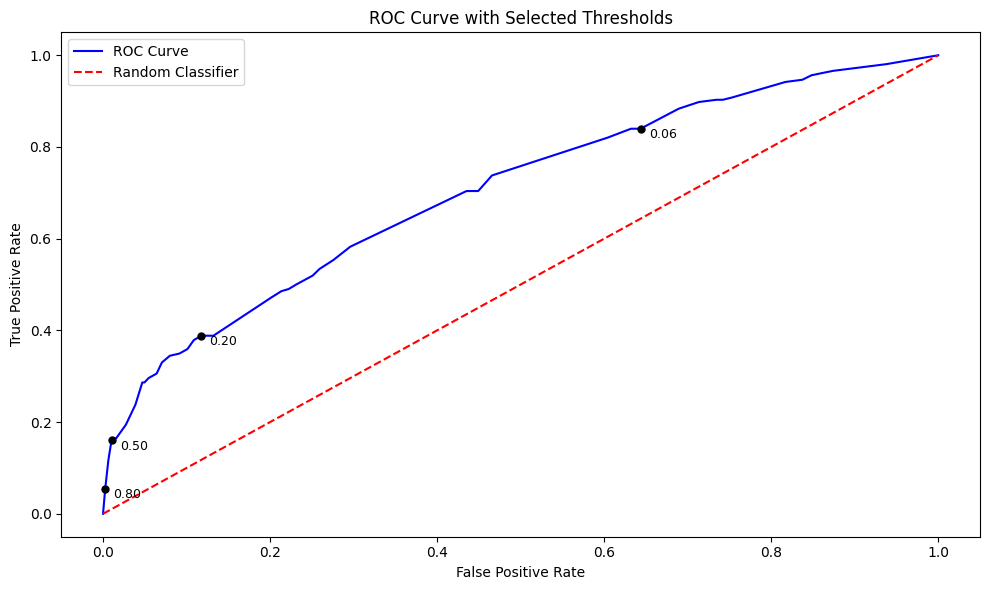

In [19]:
# Specify the thresholds you want to annotate
thresholds_to_plot = [0.2, 0.5, 0.8, 0.06]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, cv.predict_proba(X_test)[:, 1])

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="ROC Curve", color="blue")
plt.plot([0, 1], [0, 1], "r--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Selected Thresholds")
plt.legend()

# Annotate only the specified thresholds
for threshold in thresholds_to_plot:
    idx = (np.abs(thresholds - threshold)).argmin()
    plt.plot(fpr[idx], tpr[idx], 'ko', markersize=5)
    plt.text(fpr[idx] + 0.01, tpr[idx] - 0.02, f"{threshold:.2f}", fontsize=9, color="black")

plt.tight_layout()
plt.show()


The ROC curve visualises the trade-off between true positive rate (recall) and false positive rate at every possible threshold. The annotated points show where our selected thresholds (0.06, 0.2, 0.5, 0.8) fall on this curve. In our business context, we are willing to move towards the upper-right corner (more contacts, more catches) rather than the lower-left (fewer contacts, more misses).

## 10. Logistic Regression

We train a second model — Logistic Regression — to compare against the Decision Tree. Unlike trees, Logistic Regression requires **scaled features** because it is sensitive to different value ranges. We therefore create a new preprocessing pipeline that includes `StandardScaler` for numeric features.

The hyperparameter `C` controls regularisation strength: smaller values create simpler models that are less likely to overfit. We also test different class weights to handle the imbalance.

In [20]:

from sklearn.preprocessing import StandardScaler

# New numeric pipeline WITH scaling (needed for Logistic Regression)
numeric_pipeline_scaled = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# New preprocessor with scaling
preprocessor_scaled = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, make_column_selector(dtype_include=['object', 'category'])),
        ('num', numeric_pipeline_scaled, make_column_selector(dtype_include=['number']))
    ],
    remainder='passthrough'
)

# Logistic Regression pipeline
pipeline_lr = Pipeline([
    ('preprocess', preprocessor_scaled),
    ('var_filter', VarianceThreshold(threshold=0.01)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])


params_lr = {
    'var_filter__threshold': [0.0, 0.01, 0.02],
    'classifier__solver': ['liblinear'],
    'classifier__penalty': ['l2'],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__class_weight': [None, 'balanced', {0: 1, 1: 3}],
    'classifier__max_iter': [2000]
}

cv_lr = GridSearchCV(
    pipeline_lr,
    params_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

cv_lr.fit(X_train, y_train)

print(f"\nBest parameters: {cv_lr.best_params_}")
print(f"Best CV ROC-AUC: {cv_lr.best_score_:.3f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid thi


Best parameters: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__max_iter': 2000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'var_filter__threshold': 0.0}
Best CV ROC-AUC: 0.736


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid thi

### 10.1 Logistic Regression Evaluation

In [21]:
y_pred_lr = cv_lr.predict(X_test)
y_prob_lr = cv_lr.predict_proba(X_test)[:, 1]
y_prob_lr = cv_lr.predict_proba(X_test)[:, 1]



test_accuracy_lr = accuracy_score(y_test, y_pred_lr)
test_auc_lr = roc_auc_score(y_test, y_prob_lr)

print(f"=== Optimized Logistic Regression ===")
print(f"Test Accuracy: {test_accuracy_lr:.3f}")
print(f"Test ROC-AUC:  {test_auc_lr:.3f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No Investment', 'Investment']))

print(f"\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(pd.DataFrame(cm_lr,
    index=['Actual: No', 'Actual: Yes'],
    columns=['Predicted: No', 'Predicted: Yes']))

=== Optimized Logistic Regression ===
Test Accuracy: 0.893
Test ROC-AUC:  0.709

Classification Report:
               precision    recall  f1-score   support

No Investment       0.90      0.99      0.94      1574
   Investment       0.63      0.18      0.28       206

     accuracy                           0.89      1780
    macro avg       0.76      0.58      0.61      1780
 weighted avg       0.87      0.89      0.87      1780


Confusion Matrix:
             Predicted: No  Predicted: Yes
Actual: No            1552              22
Actual: Yes            169              37


### 10.2 ROC Curve and Threshold Analysis — Logistic Regression

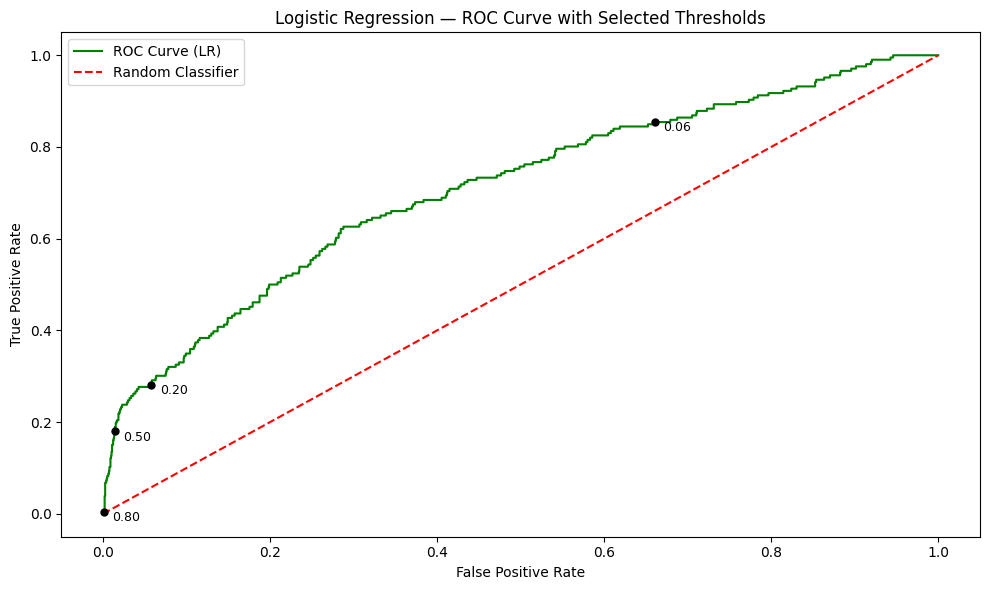

In [22]:

# ROC Curve with threshold annotations — Logistic Regression
thresholds_to_plot_lr = [0.2, 0.5, 0.8, 0.06]

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, cv_lr.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label="ROC Curve (LR)", color="green")
plt.plot([0, 1], [0, 1], "r--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression — ROC Curve with Selected Thresholds")
plt.legend()

for threshold in thresholds_to_plot_lr:
    idx = (np.abs(thresholds_lr - threshold)).argmin()
    plt.plot(fpr_lr[idx], tpr_lr[idx], 'ko', markersize=5)
    plt.text(fpr_lr[idx] + 0.01, tpr_lr[idx] - 0.02, f"{threshold:.2f}", fontsize=9, color="black")

plt.tight_layout()
plt.show()


In [23]:
#create confusion matrix based on those different threshold 
thresholds = [0.2, 0.5, 0.8, 0.06]
for thresh in thresholds:
    y_pred_thresh_lr = (y_prob_lr >= thresh).astype(int)
    cm_thresh_lr = confusion_matrix(y_test, y_pred_thresh_lr)
    print(f"\nConfusion Matrix at threshold {thresh}:")
    print(pd.DataFrame(cm_thresh_lr,
        index=['Actual: No', 'Actual: Yes'],
        columns=['Predicted: No', 'Predicted: Yes']))


Confusion Matrix at threshold 0.2:
             Predicted: No  Predicted: Yes
Actual: No            1487              87
Actual: Yes            148              58

Confusion Matrix at threshold 0.5:
             Predicted: No  Predicted: Yes
Actual: No            1552              22
Actual: Yes            169              37

Confusion Matrix at threshold 0.8:
             Predicted: No  Predicted: Yes
Actual: No            1573               1
Actual: Yes            206               0

Confusion Matrix at threshold 0.06:
             Predicted: No  Predicted: Yes
Actual: No             519            1055
Actual: Yes             30             176


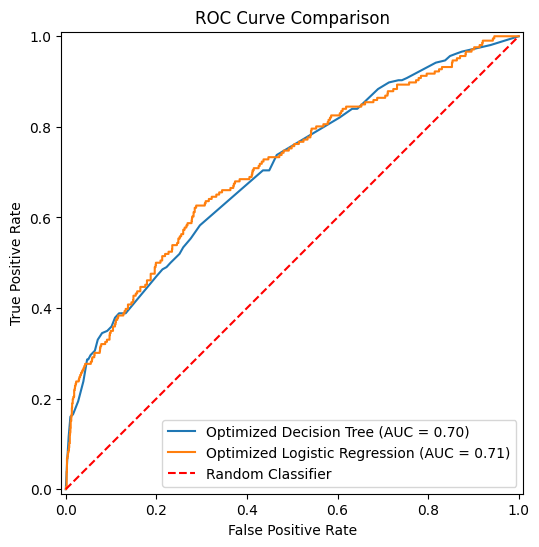

In [24]:
# plot ROC AUC for both models
plt.figure(figsize=(10, 6))
RocCurveDisplay.from_estimator(cv, X_test, y_test, name="Optimized Decision Tree", ax=plt.gca())
RocCurveDisplay.from_estimator(cv_lr, X_test, y_test, name="Optimized Logistic Regression", ax=plt.gca())
plt.plot([0, 1], [0, 1], "r--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()

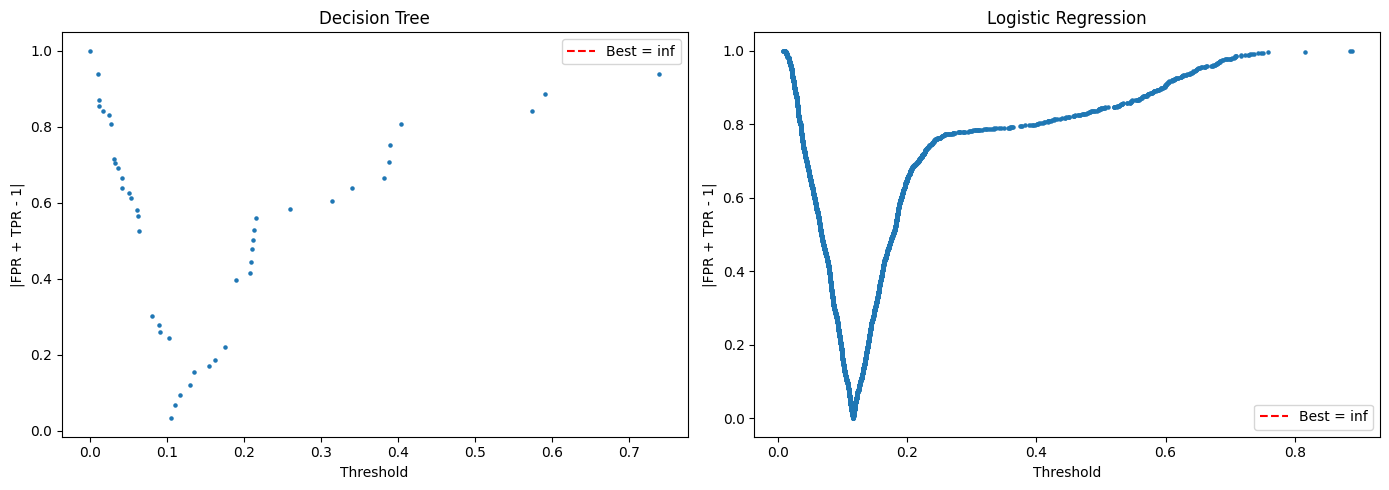

Decision Tree — optimal threshold: inf
Logistic Regression — optimal threshold: inf


In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Decision Tree
fpr_dt, tpr_dt, thresh_dt = roc_curve(y_train, cv.predict_proba(X_train)[:, 1], drop_intermediate=False)
youden_dt = np.abs(fpr_dt + tpr_dt - 1)
best_idx_dt = np.argmax(youden_dt)

axes[0].scatter(thresh_dt, youden_dt, s=5)
axes[0].axvline(thresh_dt[best_idx_dt], color='r', linestyle='--', label=f'Best = {thresh_dt[best_idx_dt]:.3f}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel("|FPR + TPR - 1|")
axes[0].set_title('Decision Tree')
axes[0].legend()

# Logistic Regression
fpr_lr, tpr_lr, thresh_lr = roc_curve(y_train, cv_lr.predict_proba(X_train)[:, 1], drop_intermediate=False)
youden_lr = np.abs(fpr_lr + tpr_lr - 1)
best_idx_lr = np.argmax(youden_lr)

axes[1].scatter(thresh_lr, youden_lr, s=5)
axes[1].axvline(thresh_lr[best_idx_lr], color='r', linestyle='--', label=f'Best = {thresh_lr[best_idx_lr]:.3f}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel("|FPR + TPR - 1|")
axes[1].set_title('Logistic Regression')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Decision Tree — optimal threshold: {thresh_dt[best_idx_dt]:.3f}")
print(f"Logistic Regression — optimal threshold: {thresh_lr[best_idx_lr]:.3f}")

The Youden's J statistic (`|FPR + TPR − 1|`) helps identify the **statistically optimal threshold** for each model — the point where the trade-off between sensitivity and specificity is maximised. However, in our business case, the optimal threshold may differ because the costs of false positives and false negatives are asymmetric.

## 11. Model Comparison

In [26]:
comparison = pd.DataFrame({
    'Model': ['Decision Tree', 'Logistic Regression'],
    'Accuracy': [test_accuracy, test_accuracy_lr],
    'ROC-AUC': [test_auc, test_auc_lr],
    
})

print(comparison.to_string(index=False))

              Model  Accuracy  ROC-AUC
      Decision Tree  0.893820 0.703069
Logistic Regression  0.892697 0.708625


Both models were compared on ROC-AUC and accuracy. For our business case, **ROC-AUC is the decisive metric**: we do not need hard yes/no predictions. Instead, we rank all Period 2 clients by their predicted probability of being profitable and select the top candidates. A higher ROC-AUC means the model is better at placing truly profitable clients at the top of this ranking.

Based on this comparison, **Logistic Regression is selected as the final model** for the Period 2 prediction, as it achieves the best ROC-AUC.

## 12. Period 2 Prediction — Scoring and Ranking Clients

We now apply the trained Logistic Regression model to the Period 2 dataset to predict each client's probability of being profitable. Clients are ranked by this probability in descending order.

In [45]:
# Table: predicted probability per person in the period_2_prediction.csv test set
# Score + rank Period 2 using predicted probabilities
df_2_ranked = pd.read_csv("period_2_prediction.csv").copy()

# Ensure same feature columns as training
X_period2 = df_2_ranked.reindex(columns=X_train.columns, fill_value=np.nan)

# Predict probability of class 1 (invest/profit)
df_2_ranked["proba_invest"] = cv_lr.predict_proba(X_period2)[:, 1]

# Rank descending (highest probability first)
df_2_ranked = df_2_ranked.sort_values("proba_invest", ascending=False).reset_index(drop=True)
df_2_ranked["rank"] = df_2_ranked.index + 1

# Select top N clients to contact
top_n = 1200
df_2_ranked["target"] = 0
df_2_ranked.loc[df_2_ranked["rank"] <= top_n, "target"] = 1

# Save full ranking + submission
df_2_ranked.to_csv("period_2_ranked.csv", index=False)
submission_p2 = df_2_ranked[["id", "target"]].copy()
submission_p2.to_csv("submission_period_2.csv", index=False)

print(df_2_ranked[["id", "proba_invest", "rank", "target"]].head(15))
print("Saved: period_2_ranked.csv and submission_period_2.csv")

#find how many higher probability than 0.17
num_high_proba = (df_2_ranked["proba_invest"] > 0.5).sum()
print(f"Number of clients with predicted probability > 0.5: {num_high_proba}")


       id  proba_invest  rank  target
0   21971      0.839745     1       1
1   15845      0.786565     2       1
2   20250      0.774263     3       1
3   17278      0.767746     4       1
4   17728      0.762973     5       1
5   21050      0.754926     6       1
6   19272      0.743891     7       1
7   22954      0.741383     8       1
8   20148      0.732006     9       1
9   22470      0.717240    10       1
10  20769      0.714859    11       1
11  22692      0.703193    12       1
12  19030      0.697810    13       1
13  19664      0.695351    14       1
14  15682      0.691801    15       1
Saved: period_2_ranked.csv and submission_period_2.csv
Number of clients with predicted probability > 0.5: 169


169 clients have a predicted probability above 0.5 — these are the most confident predictions and will definitely be contacted. However, since we can contact up to 1,200 clients, we have room to go beyond the pure model output. This is where we combine the ML predictions with **group-based business rules**.

## 13. Combining ML Predictions with Business Rules — Similarities to Week 1

An important insight from this delivery is that the **patterns identified by the machine learning model align closely with the business rules we developed manually in Week 1**. In particular:

- **Tertiary education** remains a strong predictor of profitable investment behaviour — both the Week 1 scoring system and the Logistic Regression coefficients assign higher importance to tertiary-educated clients.
- **Older clients (especially >60)** continue to show elevated investment propensity, consistent with the age-based rules from Week 1.
- **Management and self-employed professionals** appear prominently among high-probability segments, echoing the job-type scoring we applied previously.
- **Clients without housing or personal loans** are more likely to invest, which was also reflected in the Week 1 penalty for loan holders.
- **High marketing potential** and **higher account balances** remain key drivers — as they were in our manual scoring.

This consistency between the rule-based and ML-based approaches gives us additional confidence in the results. The ML model essentially *rediscovered* the patterns we identified through exploratory analysis, but can also capture **interactions** between features (e.g., tertiary-educated managers with high balances) that are difficult to express with simple additive scoring rules.

To leverage this, we now compute **subgroup-level utilization ratios** — the observed ratio of investment amount to account balance within specific demographic segments — and combine them with the ML-predicted probabilities to estimate **expected net profit** per client. This hybrid approach uses the ML model for probability estimation and the group-based statistics for investment-size estimation.

In [36]:
import itertools

BALANCE_COL = "balance"
AMOUNT_COL  = "investment"
INVESTS_COL = "invested"
ID_COL      = "id"
MIN_INVESTORS = 10

if 'invested' not in df_0.columns:
    df_0['invested'] = (df_0['investment'] > 0).astype(int)

def combo_summary(df_all, cols, min_count):
    g_all = df_all.groupby(cols, dropna=False)
    g_inv = df_all[df_all[INVESTS_COL] == 1].groupby(cols, dropna=False)

    n           = g_all.size().rename("n")
    n_investors = g_inv.size().rename("n_investors")
    sum_amount  = g_inv[AMOUNT_COL].sum().rename("sum_amount")
    sum_balance = g_inv[BALANCE_COL].sum().rename("sum_balance")
    avg_balance = g_all[BALANCE_COL].mean().rename("avg_balance")

    out = pd.DataFrame({
        "n": n, "n_investors": n_investors,
        "sum_amount": sum_amount, "sum_balance": sum_balance,
        "avg_balance": avg_balance,
    }).reset_index()

    out["n_investors"] = out["n_investors"].fillna(0).astype(int)
    out["sum_amount"]  = out["sum_amount"].fillna(0)
    out["sum_balance"] = out["sum_balance"].fillna(0)
    out["propensity"]  = out["n_investors"] / out["n"]
    out["utilization_ratio"] = np.where(
        out["n_investors"] >= MIN_INVESTORS,
        out["sum_amount"] / out["sum_balance"].replace(0, np.nan),
        np.nan
    )
    out["expected_rate"]   = out["propensity"] * out["utilization_ratio"]
    out["expected_profit"] = out["expected_rate"] * out["avg_balance"]
    out["stable"]          = out["n_investors"] >= MIN_INVESTORS
    out = out[out["n"] >= min_count]
    return out.sort_values(["expected_profit", "expected_rate", "n"], ascending=False)

cat_cols = df_0.select_dtypes(include=["object", "category", "string"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != ID_COL]
k = len(cat_cols)

per_combo_top = 3
min_count_floor = 10
min_count_scale = 80

def min_count_for_size(size):
    return max(min_count_floor, int(min_count_scale / size))

def format_segment(row, cols):
    return " | ".join(f"{c}={row[c] if pd.notna(row[c]) else '(missing)'}" for c in cols)

rows = []
for size in range(2, k + 1):
    min_count = min_count_for_size(size)
    for cols in itertools.combinations(cat_cols, size):
        cols = list(cols)
        out = combo_summary(df_0, cols, min_count=min_count)
        if out.empty:
            continue
        best = out[out["stable"]].head(per_combo_top).copy()
        if best.empty:
            continue
        best.insert(0, "combo", " + ".join(cols))
        best.insert(1, "combo_size", size)
        best["segment"] = best.apply(lambda r: format_segment(r, cols), axis=1)
        rows.append(best[["combo", "combo_size", "segment", "n", "n_investors",
                          "propensity", "utilization_ratio", "expected_rate",
                          "expected_profit", "avg_balance"]])

all_best = pd.concat(rows, ignore_index=True).sort_values(
    ["expected_profit", "expected_rate", "n"], ascending=False
).reset_index(drop=True)

print(f"Beste Segmente: {len(all_best)}")
display(all_best.head(20))

Beste Segmente: 360


,combo,combo_size,segment,n,n_investors,propensity,utilization_ratio,expected_rate,expected_profit,avg_balance
0,job + marital + education + loan_personal + ma...,5,job=management | marital=single | education=te...,19,15,0.789474,0.282090,0.222702,729.608314,3276.157895
1,job + marital + loan_personal + marketing_pote...,4,job=management | marital=single | loan_persona...,20,16,0.800000,0.284901,0.227920,717.379556,3147.500000
2,job + marital + education + loan_house + loan_...,6,job=management | marital=single | education=te...,14,11,0.785714,0.331750,0.260661,628.025538,2409.357143
3,job + marital + education + preferred_contact ...,5,job=management | marital=single | education=te...,17,14,0.823529,0.302482,0.249103,624.207395,2505.823529
4,job + marital + education + preferred_contact ...,6,job=management | marital=single | education=te...,17,14,0.823529,0.302482,0.249103,624.207395,2505.823529
5,job + marital + preferred_contact + loan_perso...,5,job=management | marital=single | preferred_co...,18,15,0.833333,0.305858,0.254882,613.160170,2405.666667
6,job + marital + education + preferred_contact ...,6,job=management | marital=single | education=te...,13,11,0.846154,0.331750,0.280712,581.721407,2072.307692
7,job + marital + preferred_contact + loan_house...,6,job=management | marital=single | preferred_co...,13,11,0.846154,0.331750,0.280712,581.721407,2072.307692
8,job + marital + education + preferred_contact ...,7,job=management | marital=single | education=te...,13,11,0.846154,0.331750,0.280712,581.721407,2072.307692
9,job + preferred_contact + loan_house + loan_pe...,5,job=management | preferred_contact=cellular | ...,41,31,0.756098,0.336951,0.254768,499.152480,1959.243902


### 13.1 Expected Net Profit Calculation

For each Period 2 client, we now compute:

1. **Subgroup utilization ratio**: How much of their balance do clients in this demographic segment typically invest? This is derived from the multi-feature segment analysis on Period 0 data (similar in spirit to the Week 1 rules, but using richer feature combinations).
2. **Expected gross proxy**: `utilization_ratio × balance × P(invest)` — the expected investment amount weighted by the model's confidence.
3. **Expected net profit**: `expected_gross × 0.045 − 5` — the commission revenue minus the contact cost.
4. **Profitable contact flag**: 1 if expected net profit > 0.

This approach ensures we only contact clients where the expected revenue exceeds the €5 contact cost.

In [48]:
# --- Rules aus all_best ---
def parse_segment_rule(segment_text):
    rule = {}
    parts = [p.strip() for p in str(segment_text).split("|")]
    for p in parts:
        if "=" not in p:
            continue
        k, v = p.split("=", 1)
        rule[k.strip()] = v.strip()
    return rule

rules = all_best[["segment", "combo_size", "utilization_ratio"]].copy()
rules = rules.dropna(subset=["utilization_ratio"]).copy()
rules["rule_dict"] = rules["segment"].apply(parse_segment_rule)
rules = rules.sort_values(["combo_size", "utilization_ratio"], ascending=[False, False]).reset_index(drop=True)

# --- UR zuweisen ---
period_2_people = df_2_ranked.copy()
print(period_2_people )

period_2_people["subgroup_utilization_ratio"] = np.nan

for _, r in rules.iterrows():
    rule = r["rule_dict"]
    mask = np.ones(len(period_2_people), dtype=bool)
    for col, val in rule.items():
        if col not in period_2_people.columns:
            mask &= False
            continue
        if val == "(missing)":
            mask &= period_2_people[col].isna()
        else:
            mask &= period_2_people[col].astype(str).eq(val)
    assign_mask = mask & period_2_people["subgroup_utilization_ratio"].isna()
    period_2_people.loc[assign_mask, "subgroup_utilization_ratio"] = r["utilization_ratio"]

fallback_ur = float(all_best["utilization_ratio"].median(skipna=True))
if np.isnan(fallback_ur):
    fallback_ur = 0.0
period_2_people["subgroup_utilization_ratio"] = period_2_people["subgroup_utilization_ratio"].fillna(fallback_ur)

# --- Expected Profit ---
period_2_people["expected_gross_proxy"] = (
    period_2_people["subgroup_utilization_ratio"] *
    period_2_people["balance"]*period_2_people["proba_invest"]
)
period_2_people["expected_net_profit"] = period_2_people["expected_gross_proxy"] * 0.045 - 5 
period_2_people["profitable_contact"] = (period_2_people["expected_net_profit"] > 0).astype(int)

print(f"Profitable clients: {period_2_people['profitable_contact'].sum()}")

         id  age           job  marital education preferred_contact   balance  \
0     21971   28    technician   single  tertiary          cellular   5104.60   
1     15845   27    management   single  tertiary          cellular  21006.40   
2     20250   27    technician   single  tertiary          cellular  12047.69   
3     17278   44    technician   single       NaN          cellular  11318.67   
4     17728   36    management   single  tertiary          cellular   2692.21   
...     ...  ...           ...      ...       ...               ...       ...   
7695  17398   40  entrepreneur  married   primary               NaN   3846.14   
7696  15667   41     housemaid  married   primary               NaN    165.64   
7697  17500   45    unemployed  married   primary               NaN    220.14   
7698  20303   45     housemaid  married   primary               NaN    -33.85   
7699  18150   44     housemaid  married   primary               NaN   -965.87   

     loan_house loan_person

### 13.2 Overlap Analysis: High-Probability vs. Profitable Clients

We check how many of the 169 high-probability clients (P > 0.5) also appear in the profitable contact list. A large overlap confirms that the ML predictions and the profit-based ranking are consistent.

In [51]:
# clients in the original "169 before" group (proba_invest > 0.5)
high_proba_mask = period_2_people["proba_invest"] > 0.5

# clients in the "890 profitable" group
profitable_mask = period_2_people["profitable_contact"] == 1

# overlap
overlap = period_2_people.loc[high_proba_mask & profitable_mask].copy()

print(f"High-probability clients (>0.5): {high_proba_mask.sum()}")
print(f"Profitable clients: {profitable_mask.sum()}")
print(f"Overlap (already in the 169): {len(overlap)}")

# show who they are
display(overlap[["id", "proba_invest", "expected_net_profit", "profitable_contact"]].sort_values("proba_invest", ascending=False))

High-probability clients (>0.5): 169
Profitable clients: 890
Overlap (already in the 169): 113


,id,proba_invest,expected_net_profit,profitable_contact
0,21971,0.839745,41.704199,1
1,15845,0.786565,241.666446,1
2,20250,0.774263,96.634130,1
3,17278,0.767746,84.237749,1
4,17728,0.762973,25.664953,1
...,...,...,...,...
158,22990,0.518577,2.991269,1
159,22536,0.516562,12.529556,1
164,20045,0.509784,2.444871,1
165,16331,0.509603,23.879204,1


## 14. Final Submission

We create the submission file for Period 2. The `target` column indicates which clients should be contacted (1) and which should not (0), based on the expected net profit calculation.

In [57]:
#rename profitable_contact to target and then drop everything besides id and target of dr2_ranked
df_2_ranked["target"] = period_2_people["profitable_contact"]
submission_p2 = df_2_ranked[["id", "target"]].copy()
submission_p2.to_csv("submission_period_2.csv", index=False)
print("Saved: submission_period_2.csv with target based on expected net profit")
#read csv to check
submission_check = pd.read_csv("submission_period_2.csv")
print(submission_check.head(2000))

Saved: submission_period_2.csv with target based on expected net profit
         id  target
0     21971       1
1     15845       1
2     20250       1
3     17278       1
4     17728       1
...     ...     ...
1995  15514       0
1996  21266       0
1997  16619       0
1998  20364       0
1999  22129       0

[2000 rows x 2 columns]


The final submission targets all clients where the expected net profit from contacting them is positive. This profit-driven selection strategy integrates:

1. **ML-predicted investment probability** (from Logistic Regression)
2. **Subgroup-level utilization ratios** (from segment analysis on historical data)
3. **Account balance** (as a proxy for potential investment size)
4. **Business economics** (4.5% commission minus €5 contact cost)

This ensures that every contact decision is economically justified, maximising total expected profit rather than simply maximising the number of investors found.